In [1]:
import torch
import torchvision
import torchvision.transforms as transforms
from torch.utils.data import DataLoader
import torch.nn as nn
import torch.nn.functional as F
import torch.optim as optim
import matplotlib.pyplot as plt

In [2]:
transform = transforms.Compose([transforms.ToTensor(), transforms.Normalize((0.5,),(0.5,))])

trainset = torchvision.datasets.MNIST(root="./data", train=True, download=True, transform=transform)
trainloader = DataLoader(trainset, batch_size=64, shuffle=True)

testset = torchvision.datasets.MNIST(root="./data", train=False, download=True, transform=transform)
testloader = DataLoader(testset, batch_size=64, shuffle=False)

In [3]:
class Middle_Net(nn.Module):
    def __init__(self):
        super(Middle_Net, self).__init__()
        self.fc1 = nn.Linear(28*28, 512)
        self.fc2 = nn.Linear(512, 256)
        self.fc3 = nn.Linear(256, 10)

    def forward(self, x):
        x = x.view(-1, 28*28)
        x = F.relu(self.fc1(x))
        x = F.relu(self.fc2(x))
        x = self.fc3(x)
        return x

    def __str__(self):
        return "middle_net"


class Small_Net(nn.Module):
    def __init__(self):
        super(Small_Net, self).__init__()
        self.fc1 = nn.Linear(28*28, 512)
        self.fc2 = nn.Linear(512, 10)

    def forward(self, x):
        x = x.view(-1, 28*28)
        x = F.relu(self.fc1(x))
        x = self.fc2(x)
        return x

    def __str__(self):
        return "small_net"
    
class Bigger_Net(nn.Module):
    def __init__(self):
        super(Bigger_Net, self).__init__()
        self.fc1 = nn.Linear(28*28, 1024)
        self.fc2 = nn.Linear(1024, 512)
        self.fc3 = nn.Linear(512, 256)
        self.fc4 = nn.Linear(256, 10)

    def forward(self, x):
        x = x.view(-1, 28*28)
        x = F.relu(self.fc1(x))
        x = F.relu(self.fc2(x))
        x = F.relu(self.fc3(x))
        x = self.fc4(x)
        return x
    
    def __str__(self):
        return "bigger_net"

bigger_net = Bigger_Net()
middle_net = Middle_Net() 
small_net = Small_Net()


In [4]:
criterion = nn.CrossEntropyLoss()

net_opt_pairs = []

bigger_optimizer = optim.SGD(bigger_net.parameters(), lr=0.001, momentum=0.9)
middle_optimizer = optim.SGD(middle_net.parameters(), lr=0.001, momentum=0.9)
small_optimizer = optim.SGD(small_net.parameters(), lr=0.001, momentum=0.9)

net_opt_pairs.append((bigger_net,bigger_optimizer))
net_opt_pairs.append((middle_net,middle_optimizer))
net_opt_pairs.append((small_net,small_optimizer))

In [5]:
for epoch in range(10):  # loop over the dataset multiple times
    running_losses = []
    for i in range(len(net_opt_pairs)):
        running_losses.append(0.0)
    for i, data in enumerate(trainloader, 0):
        inputs, labels = data
        for idx, (net, opt) in enumerate(net_opt_pairs):
            opt.zero_grad()
            outputs = net(inputs)
            loss = criterion(outputs, labels)
            loss.backward()
            opt.step()
            running_losses[idx] += loss.item()
        if i % 200 == 199:    # print every 200 mini-batches
            str = ""
            for j in range(len(net_opt_pairs)):
                str += f"[{epoch+1}, {i+1}] {net_opt_pairs[j][0]}: {running_losses[j]/200:.4f}        "
                running_losses[j] = 0.0
            print(str)

[1, 200] bigger_net: 2.2211        [1, 200] middle_net: 2.0411        [1, 200] small_net: 1.5115        
[1, 400] bigger_net: 1.6939        [1, 400] middle_net: 1.1020        [1, 400] small_net: 0.6850        
[1, 600] bigger_net: 0.8879        [1, 600] middle_net: 0.6117        [1, 600] small_net: 0.5029        
[1, 800] bigger_net: 0.5921        [1, 800] middle_net: 0.4952        [1, 800] small_net: 0.4529        
[2, 200] bigger_net: 0.4411        [2, 200] middle_net: 0.4081        [2, 200] small_net: 0.3943        
[2, 400] bigger_net: 0.3924        [2, 400] middle_net: 0.3689        [2, 400] small_net: 0.3607        
[2, 600] bigger_net: 0.3799        [2, 600] middle_net: 0.3618        [2, 600] small_net: 0.3598        
[2, 800] bigger_net: 0.3626        [2, 800] middle_net: 0.3487        [2, 800] small_net: 0.3501        
[3, 200] bigger_net: 0.3375        [3, 200] middle_net: 0.3296        [3, 200] small_net: 0.3334        
[3, 400] bigger_net: 0.3215        [3, 400] middle_net:

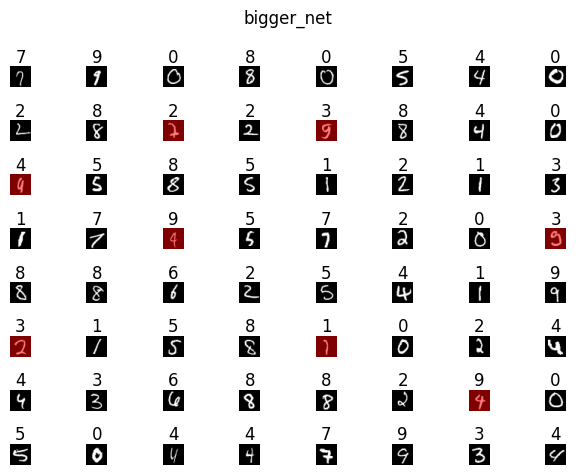

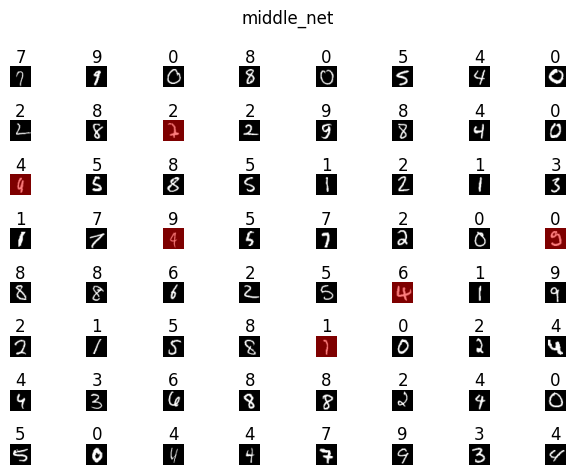

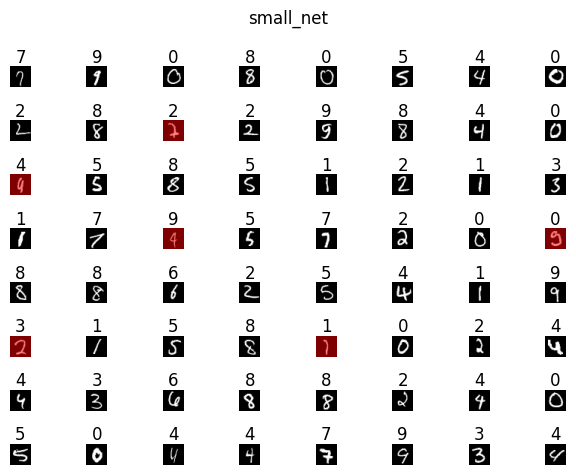

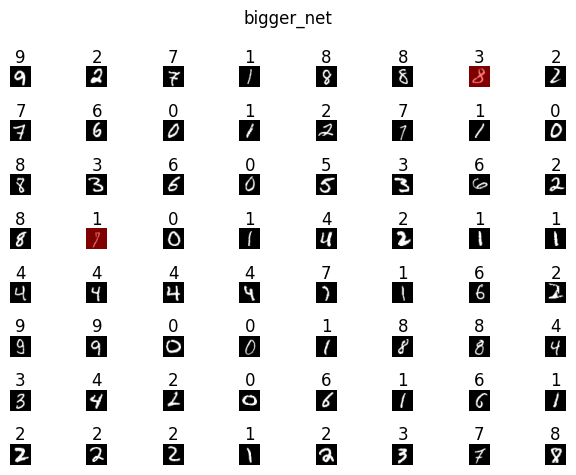

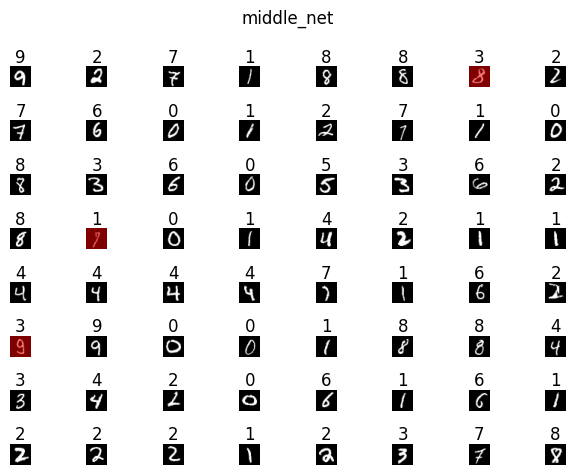

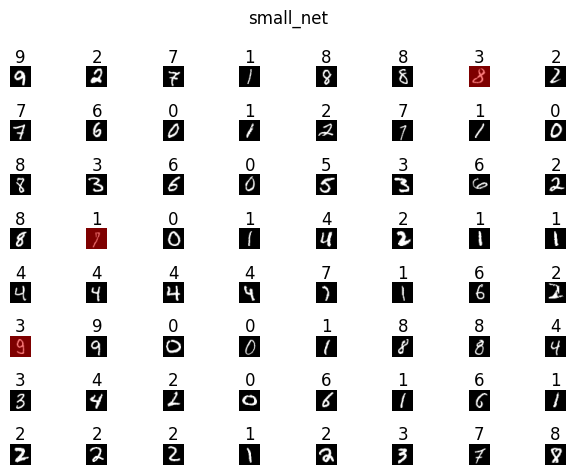

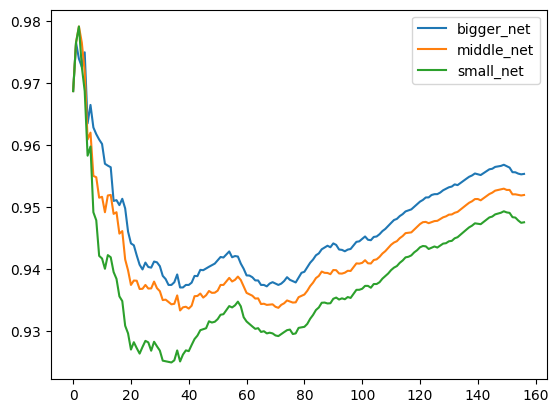

In [10]:
import numpy as np

corrects = [0 for i in range(len(net_opt_pairs))]
total = 0
percents = [list() for i in range(len(net_opt_pairs))]
for i, data in enumerate(testloader):
    rn = np.random.binomial(1,0.99)
    inputs,labels = data
    total += labels.shape[0]
    with torch.no_grad():
        for net_idx, (net,_) in enumerate(net_opt_pairs):
            labels_hat = net(inputs)
            correct_now = (labels_hat.argmax(axis=1)==labels).sum()
            corrects[net_idx] += correct_now
            percents[net_idx].append(corrects[net_idx]/total)

            if rn == 1 : continue
            for i in range(64):
                plt.subplot(8,8,i+1)
                plt.axis("off")
                plt.title(labels_hat[i].argmax().item(), ha='center', va='center') 
                plt.imshow(inputs[i][0], cmap="gray")  
                
                if labels[i] != labels_hat[i].argmax().item():
                    red_tile = np.ones((28,28,3))
                    red_tile[:,:,0] = 1
                    red_tile[:,:,1] = 0
                    red_tile[:,:,2] = 0
                    plt.imshow(red_tile, alpha=0.5)
            plt.suptitle(f"{net_opt_pairs[net_idx][0]}")
            plt.tight_layout()
            plt.show()
for i in range(len(net_opt_pairs)):
    plt.plot(percents[i], label=net_opt_pairs[i][0])  
plt.legend()

        